In [53]:
import sys
sys.path.insert(0, 'D:\Pulpit\FaceProject')

In [54]:
# !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

In [55]:
# import bz2
# fromF = bz2.open("shape_predictor_68_face_landmarks.dat.bz2", "rb")
# data = fromF.read()
# toF = open("shape_predictor_68_face_landmarks.dat", "wb")
# toF.write(data)

In [56]:
import helper as h

In [57]:
from imutils import face_utils
from scipy.spatial import Delaunay
from itertools import combinations
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [58]:
babka = cv2.imread('kanye.jpg')
babka = cv2.resize(babka, (600,400))
vertices = np.array([(230, 223), (227, 203), (261, 192)], dtype=np.float32)
ja = cv2.imread('ja.jpg')
ja = cv2.resize(ja, (600,400))
new_vertices = np.array([(289, 180), (288, 164), (311, 151)], dtype=np.float32)

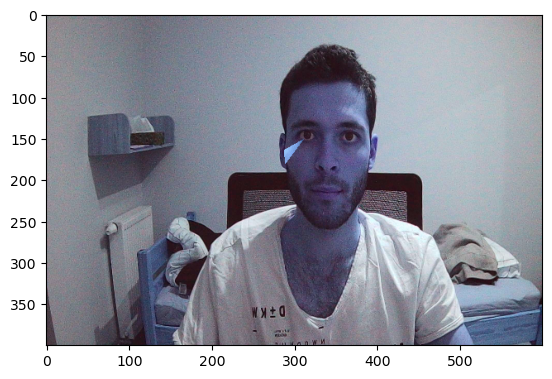

In [60]:
x = h.mapT2T(babka, ja, vertices, new_vertices)
plt.imshow(x)

In [32]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [33]:
rect = detector(ja,0)
x = predictor(ja, rect[0])
face_utils.shape_to_np(x)

array([[289, 149],
       [289, 164],
       [290, 180],
       [292, 195],
       [296, 211],
       [302, 226],
       [311, 240],
       [324, 250],
       [339, 253],
       [355, 251],
       [368, 241],
       [377, 228],
       [384, 214],
       [388, 199],
       [390, 183],
       [392, 168],
       [393, 153],
       [296, 140],
       [301, 131],
       [311, 127],
       [322, 128],
       [332, 132],
       [350, 133],
       [361, 129],
       [372, 129],
       [382, 134],
       [387, 143],
       [340, 147],
       [340, 158],
       [340, 170],
       [339, 182],
       [328, 188],
       [333, 191],
       [339, 193],
       [345, 191],
       [351, 189],
       [306, 148],
       [312, 142],
       [320, 143],
       [326, 150],
       [319, 151],
       [311, 151],
       [356, 150],
       [363, 144],
       [371, 144],
       [376, 150],
       [371, 153],
       [363, 153],
       [321, 214],
       [327, 210],
       [334, 208],
       [339, 210],
       [345,

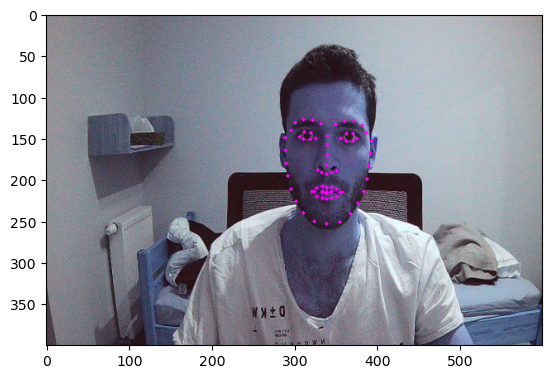

In [34]:
babkaCoords = h.drawCoords(ja)
plt.imshow(babkaCoords)

In [35]:
INDICES = h.fileToNumpy('trianglesIndices.txt')

In [36]:
INDICES.shape

(113, 3)

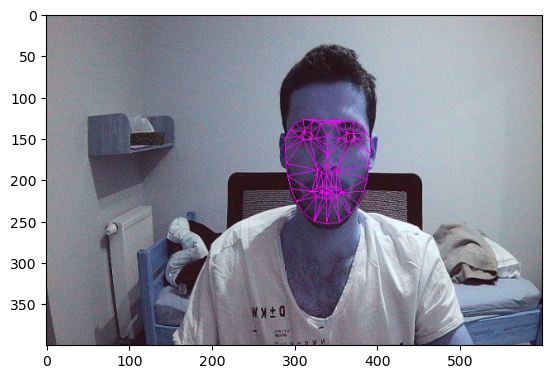

In [37]:
x = h.drawLines(ja)
plt.imshow(x)

In [38]:
indices, src_coords = h.getTrianglesCoords(babka, None)
_, dest_coords = h.getTrianglesCoords(ja, indices)

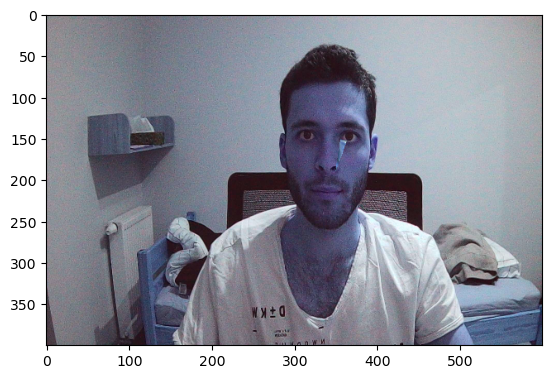

In [39]:
x = h.mapT2T(babka, ja, src_coords[10], dest_coords[10])
plt.imshow(x)

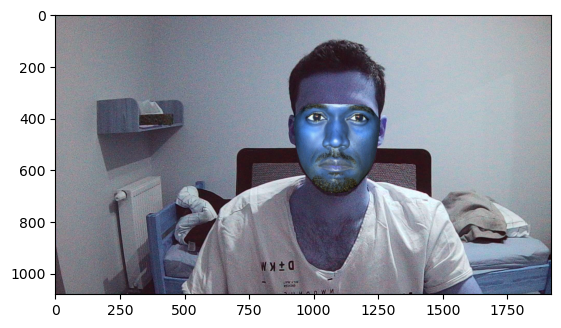

In [29]:
x = h.swapAll(babka, ja, src_coords, dest_coords)
plt.imshow(x)

In [17]:
cap = cv2.VideoCapture(0)
 
while True:
    _, image = cap.read()
    _, dest_coords = h.getTrianglesCoords(image, trianglesIndices=indices)
    if type(dest_coords) != type(None):
        x = h.swapAll(babka, image, src_coords, dest_coords)
    else:
        x = image

    cv2.imshow("Output1", x)    
    
    #close on Esc
    k = cv2.waitKey(5) & 0xFF
    if k == 27:
        break

cv2.destroyAllWindows()
cap.release()

In [62]:
from typing import Callable
from PIL import Image

In [77]:
class Face:

    def __init__(self, img: np.array, 
                 indices: np.array,
                 detector: Callable[[np.array], np.array], 
                 predictor: Callable[[np.array], np.array]) -> None:
        
        rectangle = self._init_rectangle(img, detector)
        self.indices = indices

        self.tris_coords = self._init_tris_coords(img, rectangle, predictor)
        self.tris_coords_min = self.minimize_coords(self.tris_coords)
        self.tris_bboxes = self.get_bboxes(self.tris_coords)
        self.tris_image_parts = self.get_image_parts(image=img)

        self.trans_tris_coords = None
        self.trans_tris_coords_min = None
        self.trans_tris_bboxes = None
        self.trans_tris_image_parts = None
        self.trans_masks = None

        self.transform(self.tris_coords)

    def _init_rectangle(self, image, detector) -> np.array:
        rectangles = detector(image, 0)
        try:
            assert len(rectangles) == 1
        except:
            raise AssertionError(f'faces: {len(rectangles)}, expected 1')

        return rectangles[0]

    def _init_tris_coords(self, image, rectangle, predictor) -> np.array:
        predictions = predictor(image, rectangle)
        predictions = face_utils.shape_to_np(predictions)
        return predictions[self.indices]
    
    def get_bboxes(self, tris_coords) -> np.array:
        bboxes = []
        for triangle in tris_coords:
            bboxes.append(np.array(cv2.boundingRect(triangle)))
        return np.array(bboxes)
    
    def get_image_parts(self, image) -> list:
        images = []
        for bbox in self.tris_bboxes:
            x, y, w, h = bbox
            images.append(
                image[y:y+h, x:x+w]
            )
        return images
    
    def minimize_coords(self, tris_coords) -> np.array:

        def minimize(array):            
            min = array.min()
            return array-min

        coords = tris_coords.copy()
        coords = np.apply_along_axis(minimize, 1, coords)
        return coords
    
    def transform(self, dest_coords) -> None:
        self.trans_tris_coords = dest_coords
        self.trans_tris_coords_min = self.minimize_coords(self.trans_tris_coords)
        self.trans_tris_bboxes = self.get_bboxes(self.trans_tris_coords)

        parts = []      
        masks = []  
        for idx, (src, dest) in enumerate(zip(self.tris_coords_min.astype(np.float32), 
                            self.trans_tris_coords_min.astype(np.float32))):
            
            M = cv2.getAffineTransform(src, dest)
            x, y, w, h = self.trans_tris_bboxes[idx]
            part = cv2.warpAffine(self.tris_image_parts[idx], M, (w, h))
            parts.append(part)
            mask = np.zeros((h, w), dtype=np.uint8)
            cv2.fillConvexPoly(mask, dest.astype(int), (255))
            masks.append(mask)

        self.trans_tris_image_parts = parts
        self.trans_masks = masks


ja = cv2.imread('ja.jpg')
f = Face(ja, INDICES, detector, predictor)

C:\Users\stani\AppData\Local\Temp\ipykernel_2488\3779998452.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


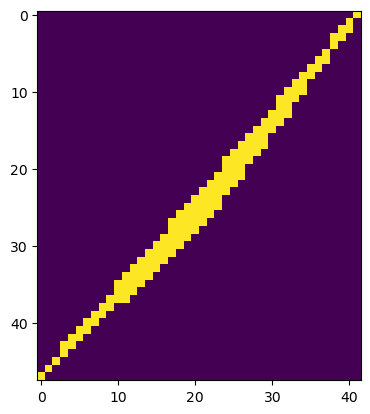

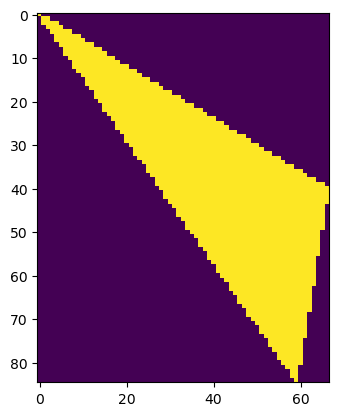

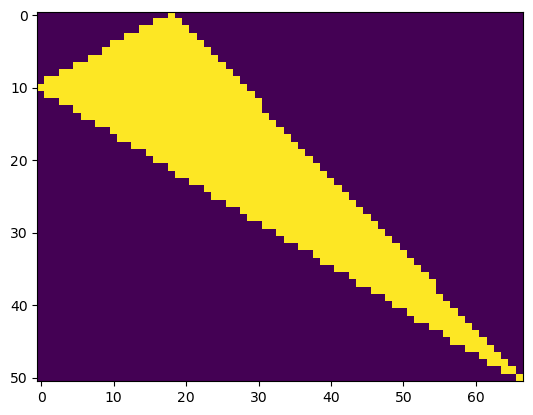

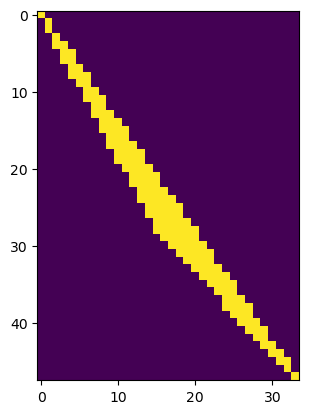

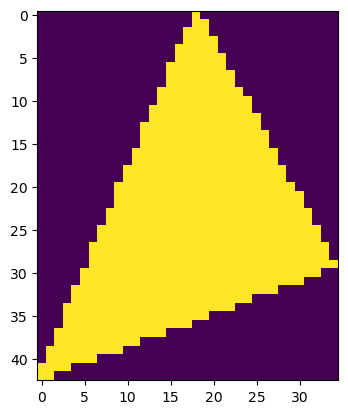

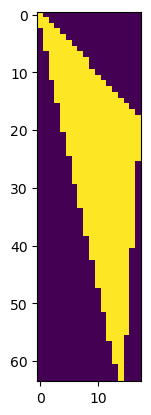

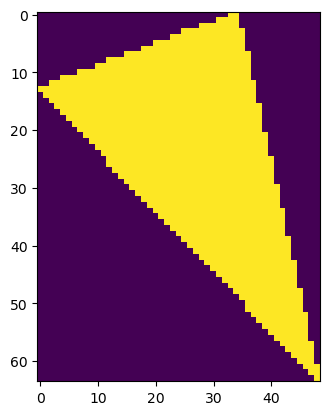

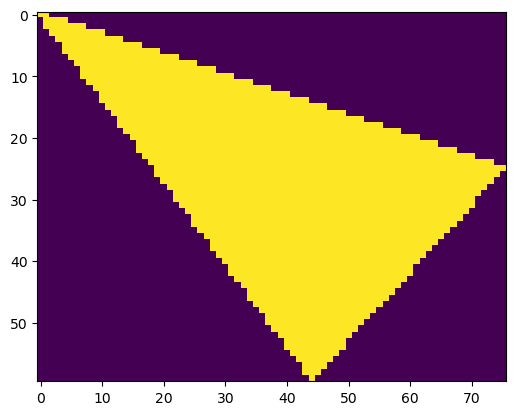

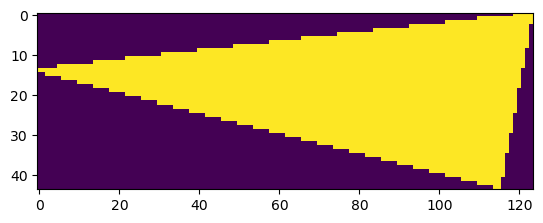

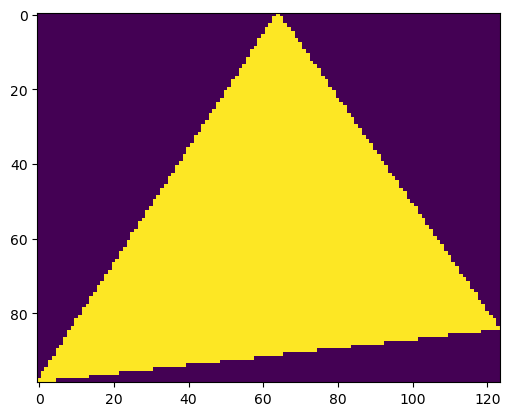

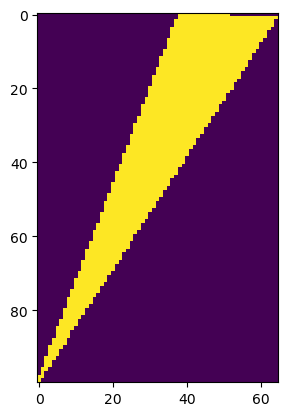

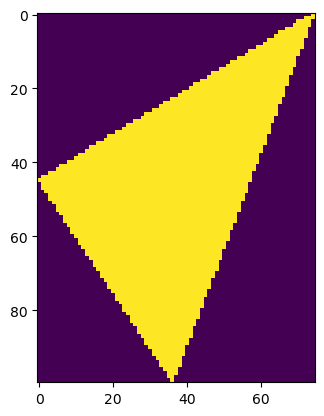

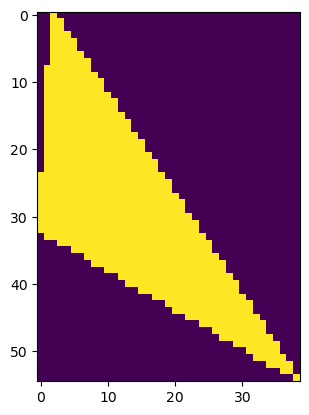

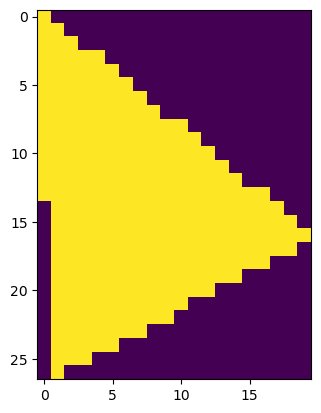

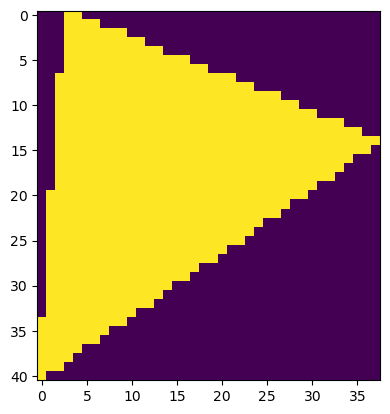

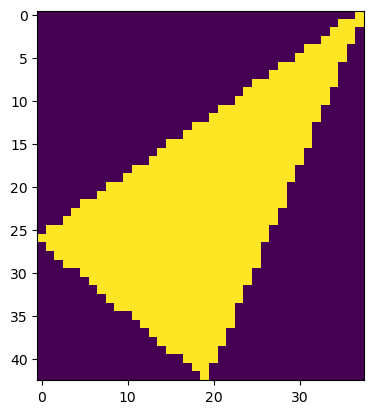

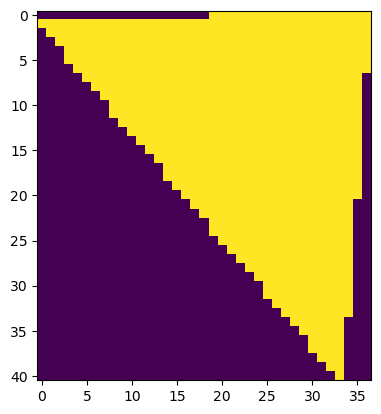

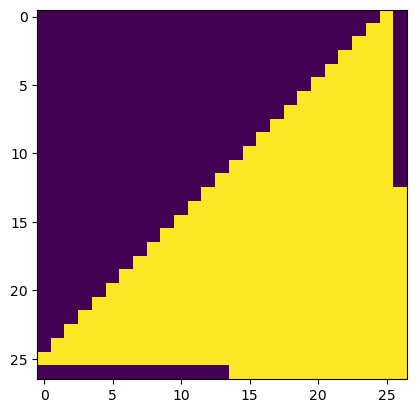

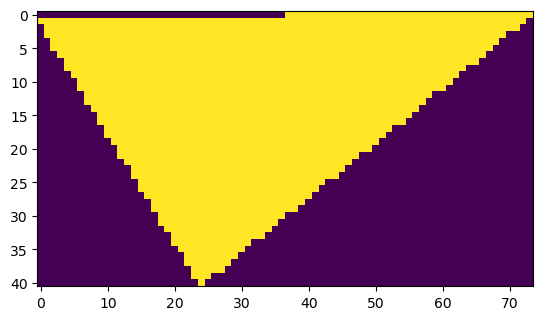

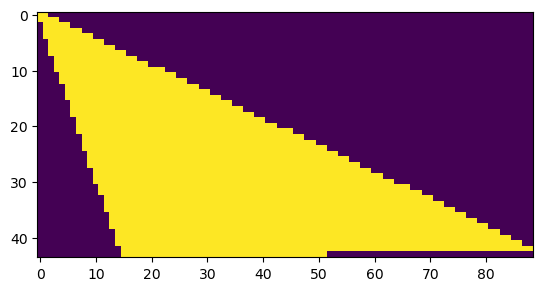

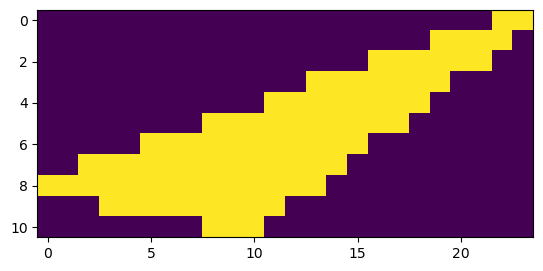

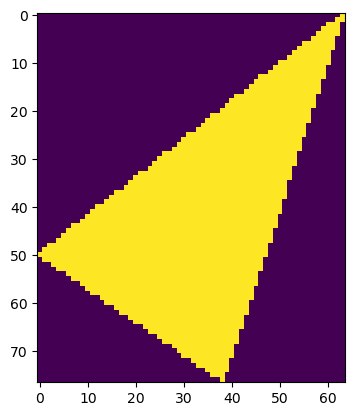

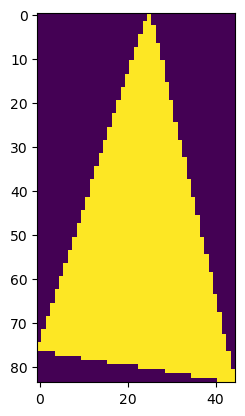

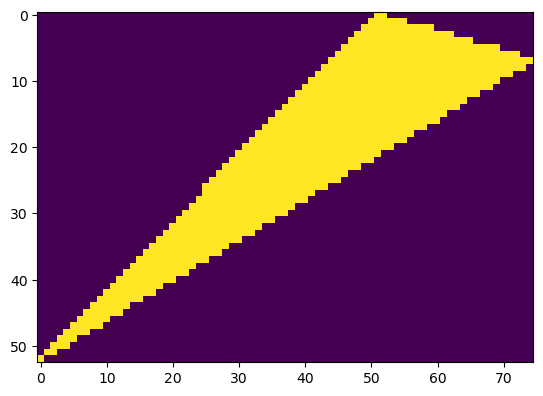

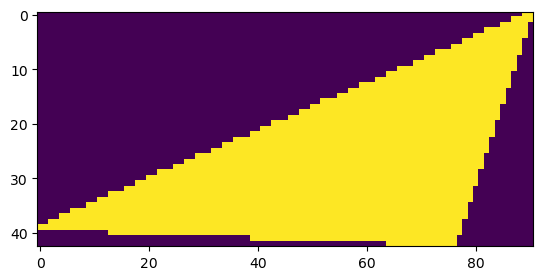

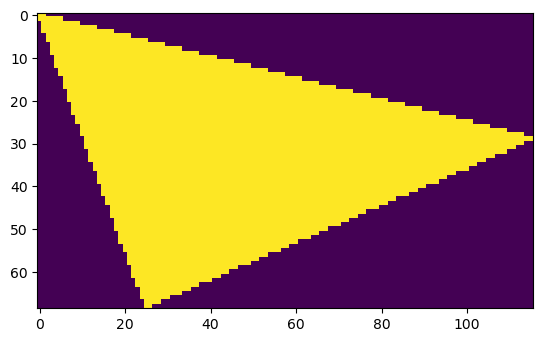

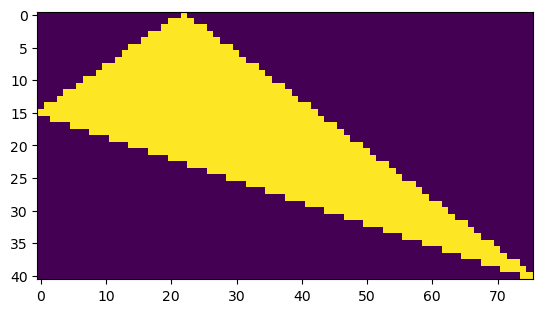

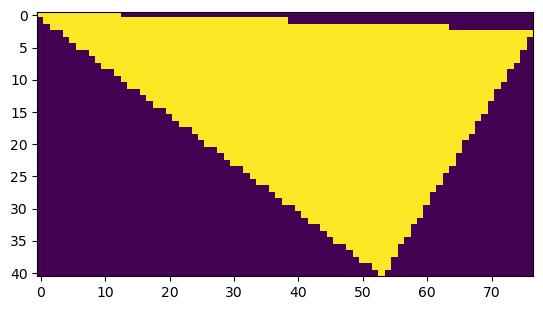

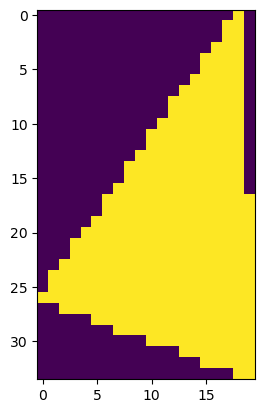

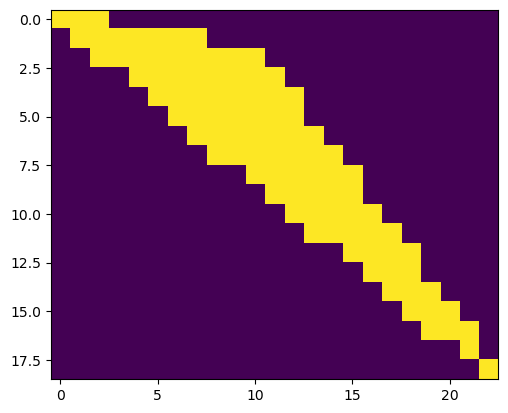

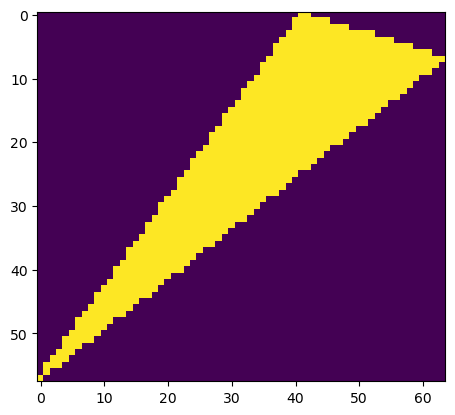

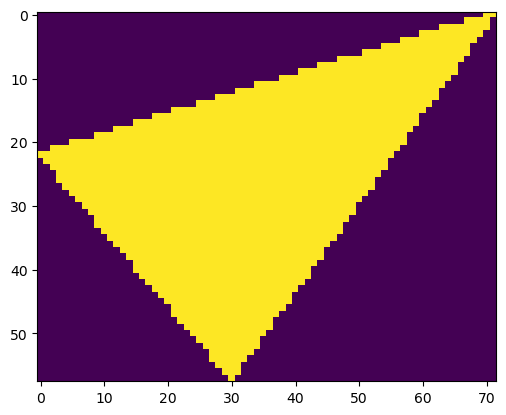

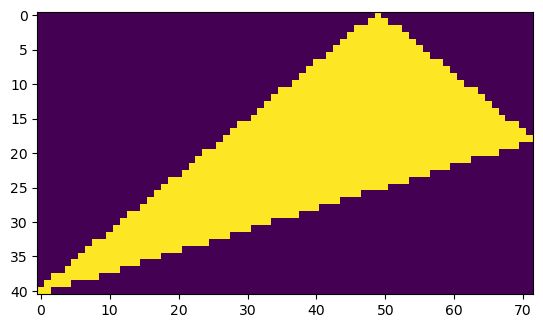

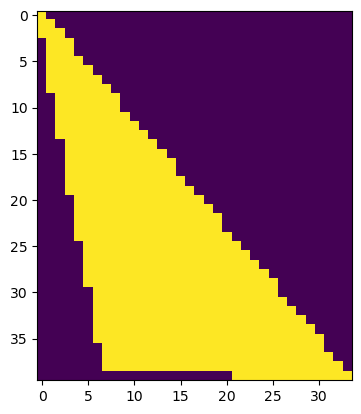

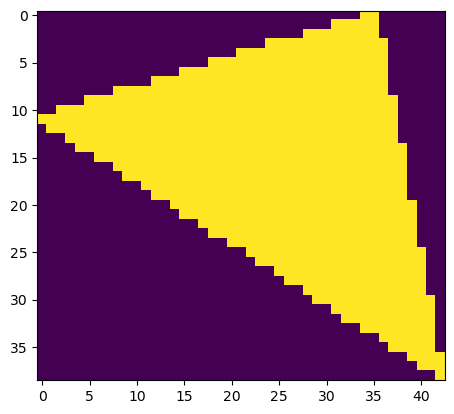

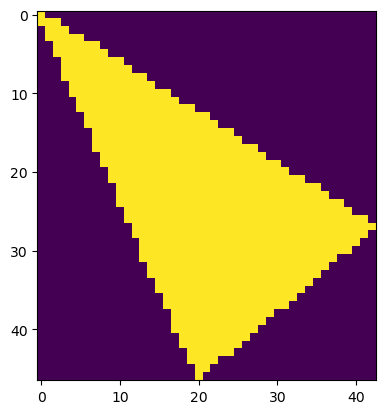

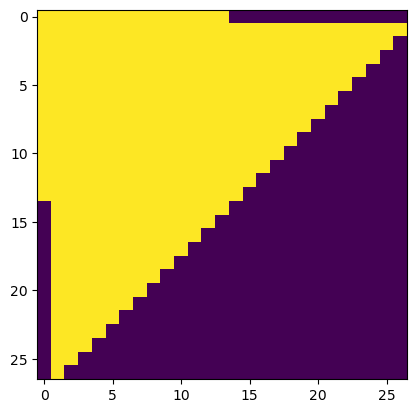

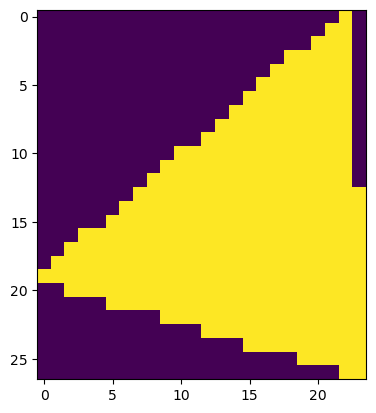

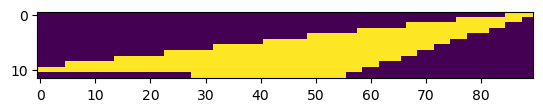

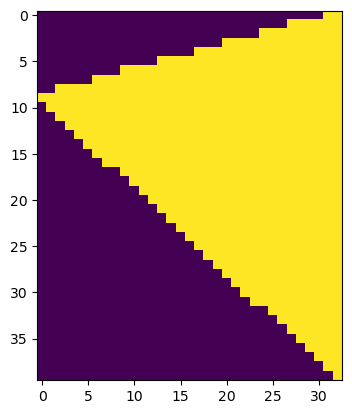

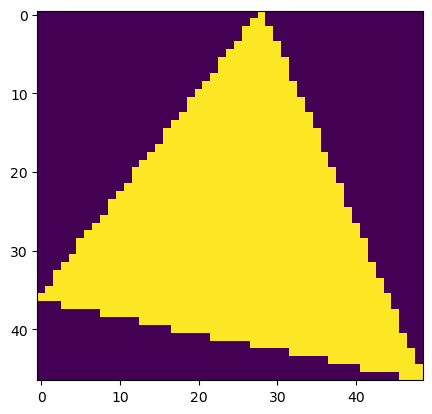

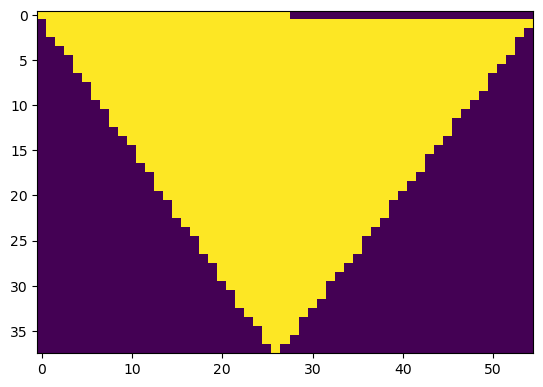

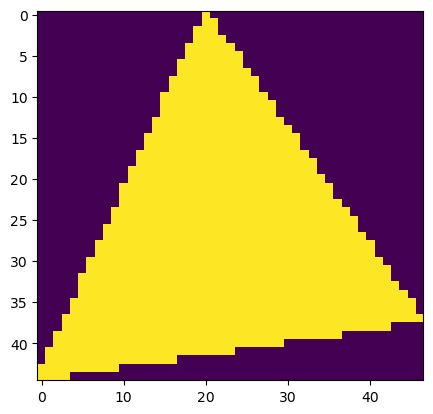

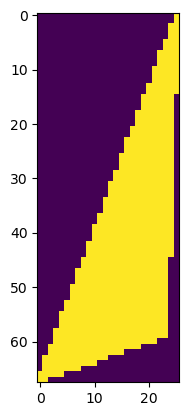

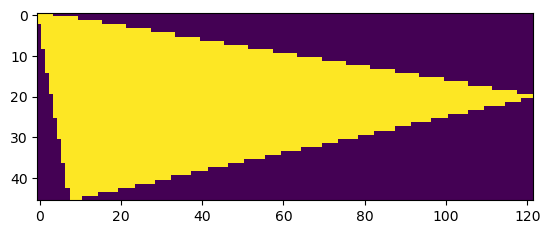

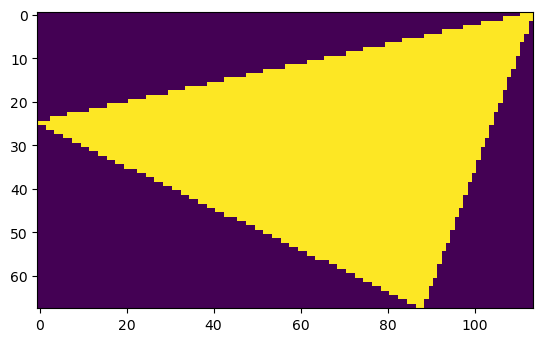

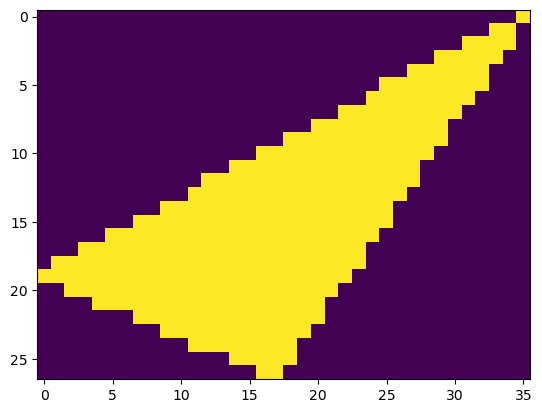

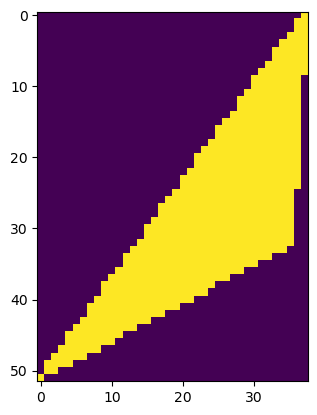

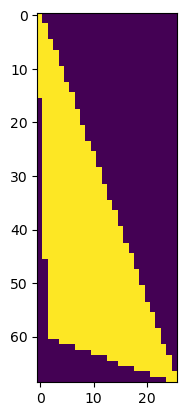

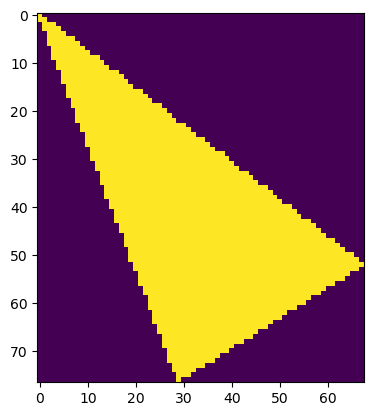

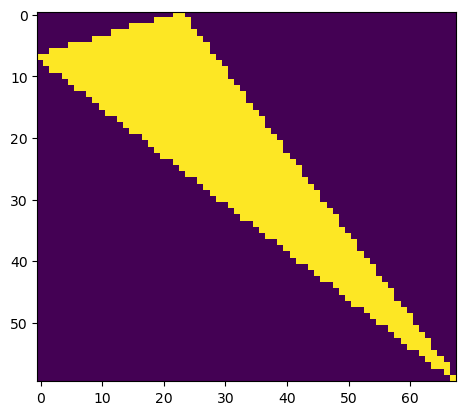

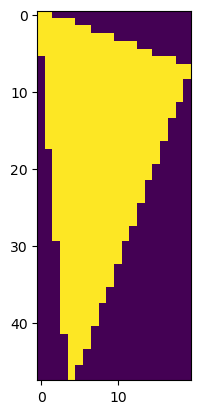

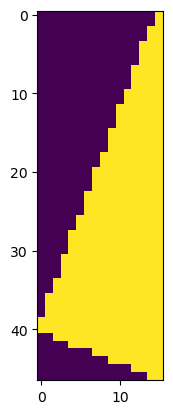

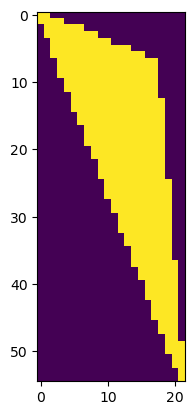

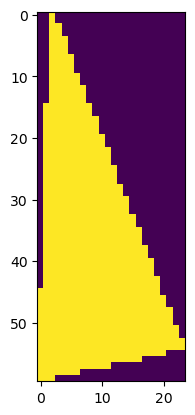

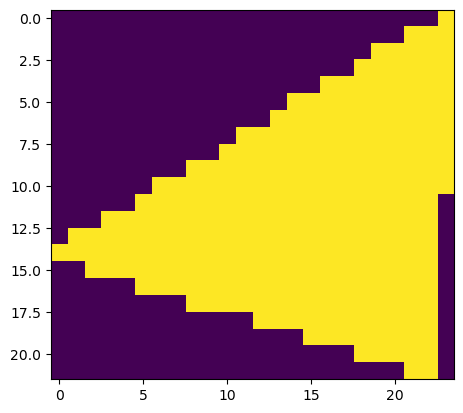

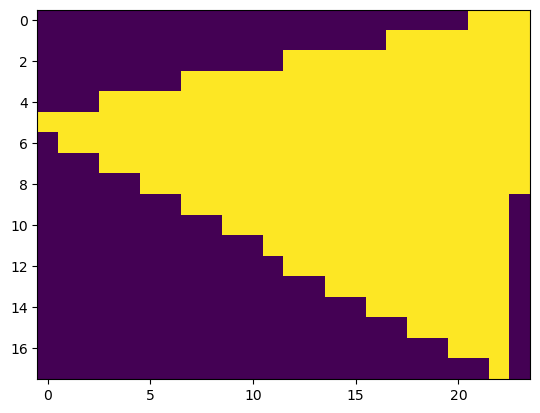

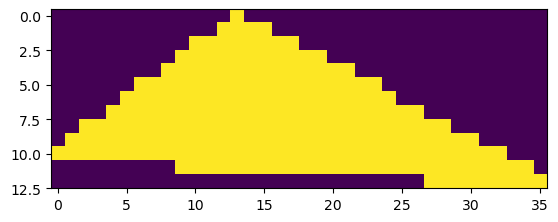

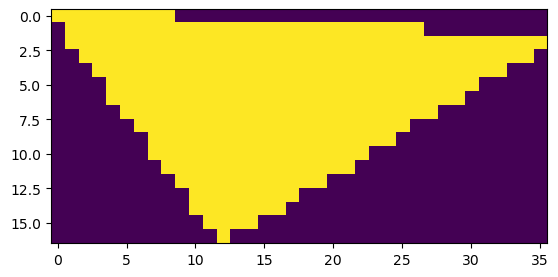

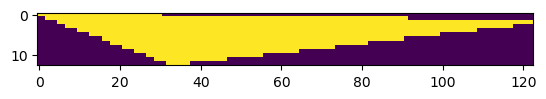

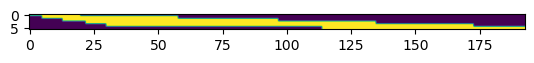

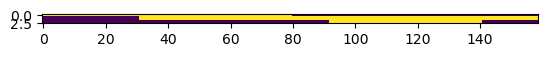

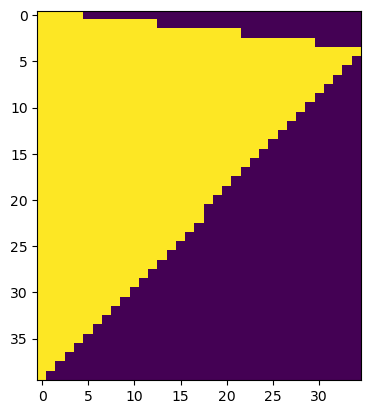

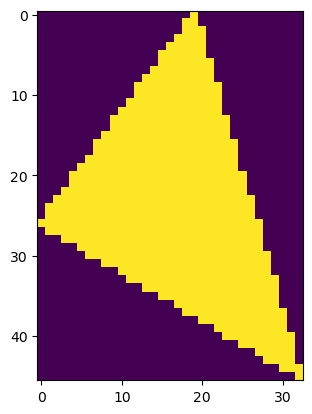

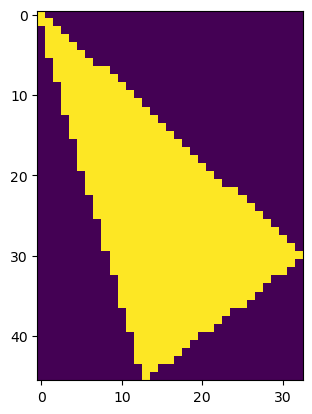

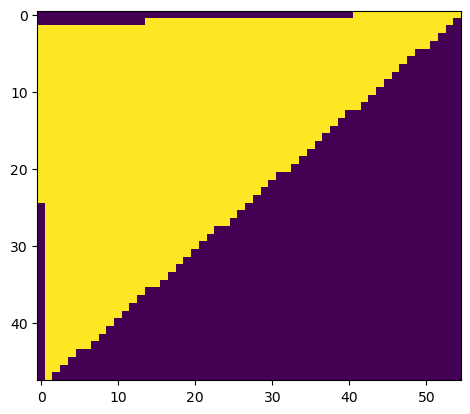

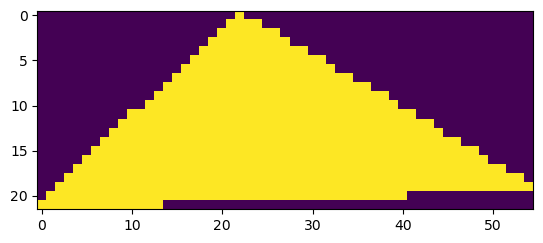

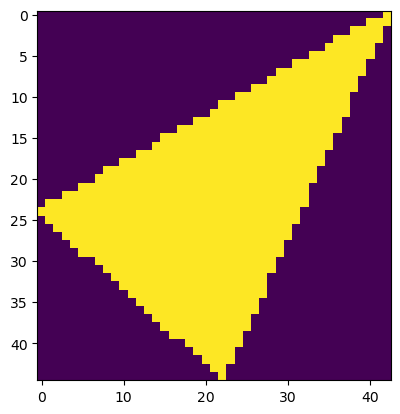

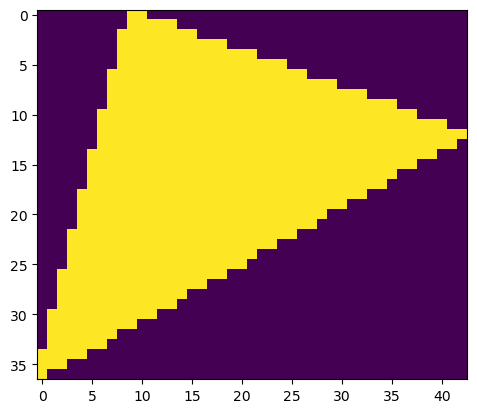

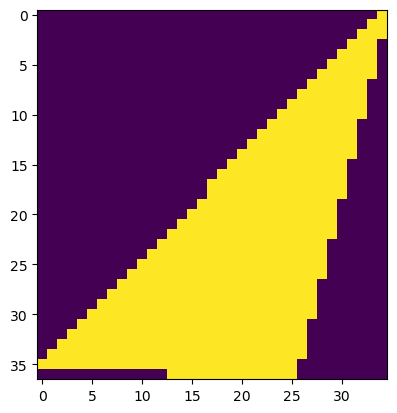

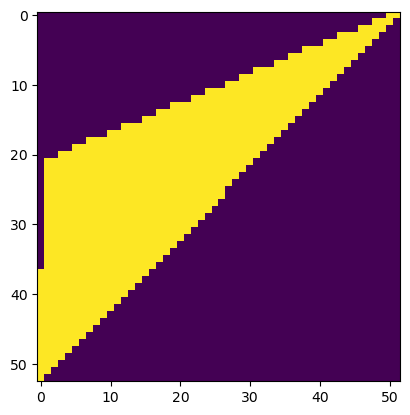

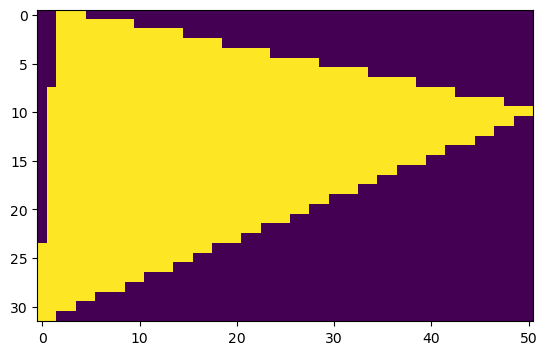

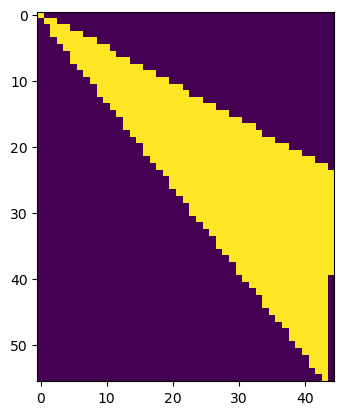

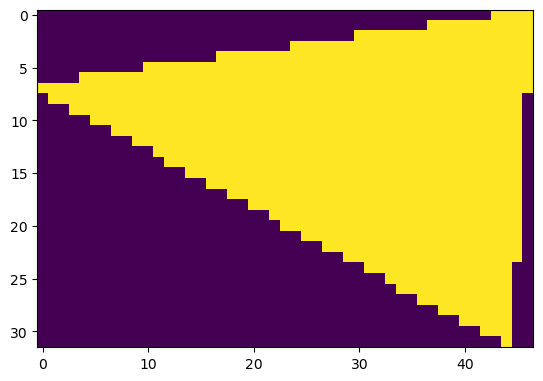

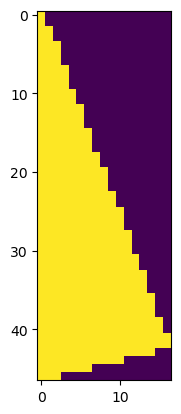

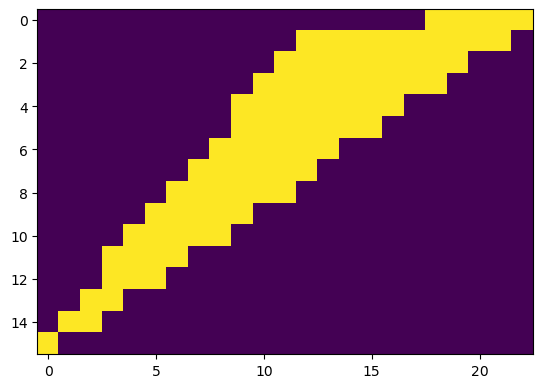

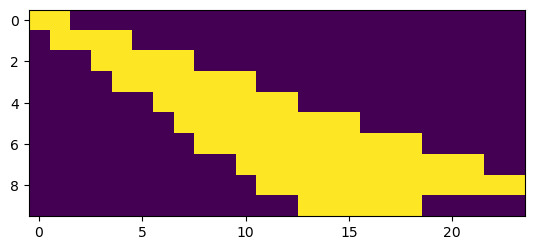

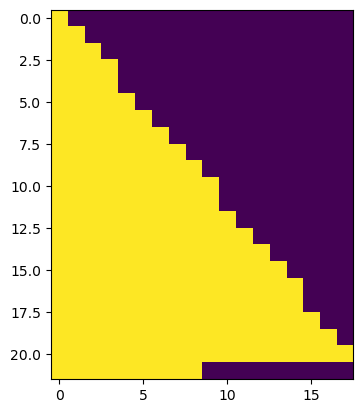

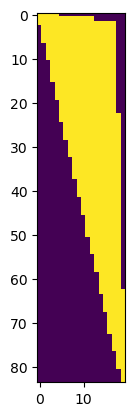

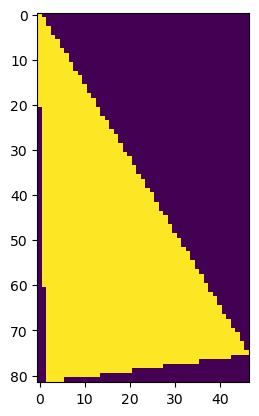

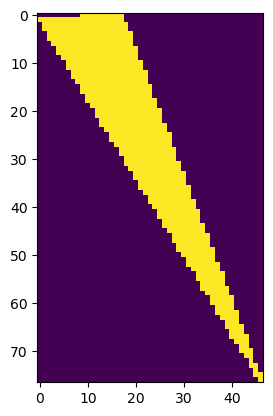

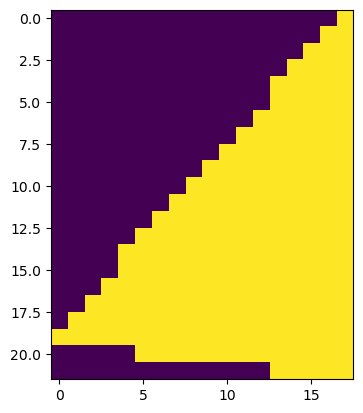

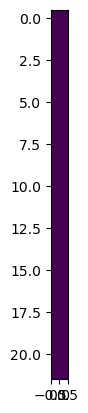

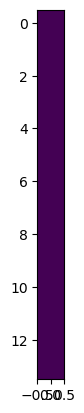

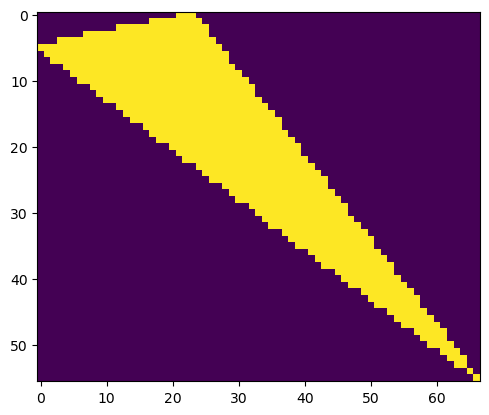

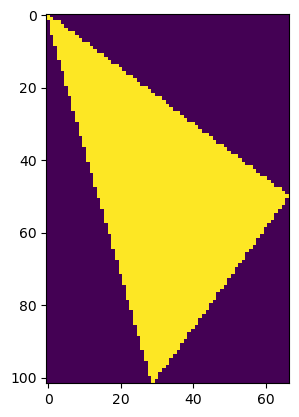

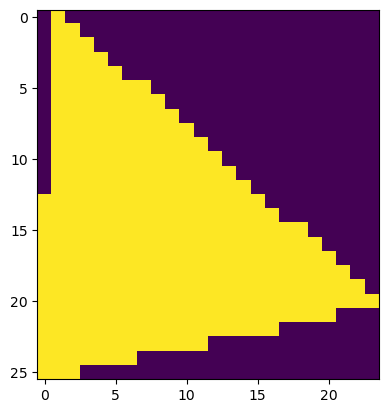

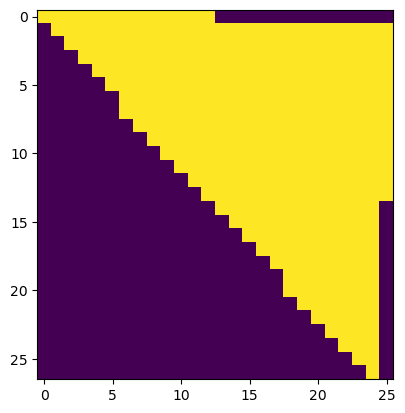

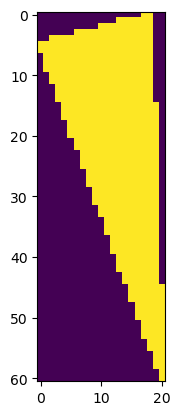

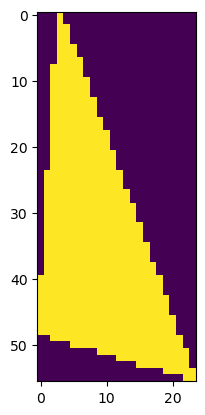

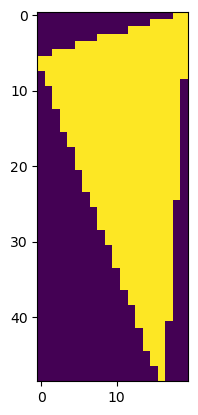

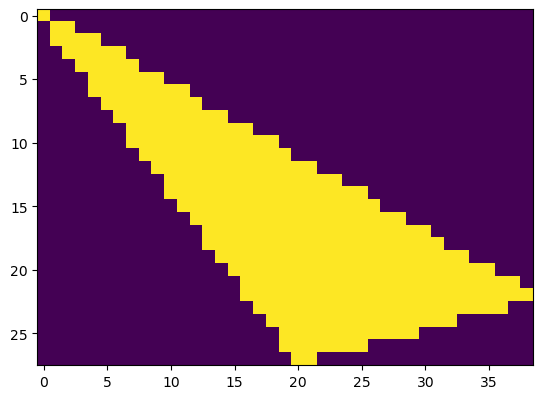

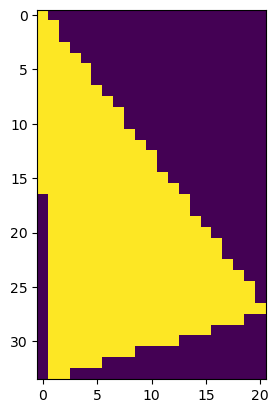

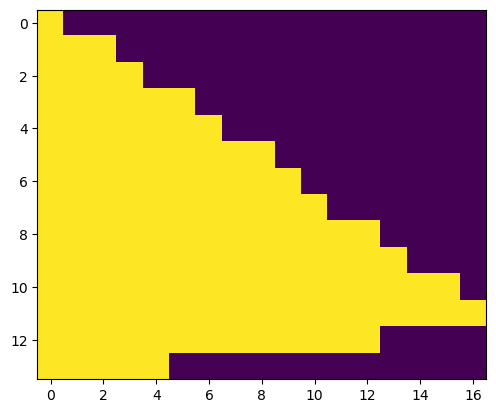

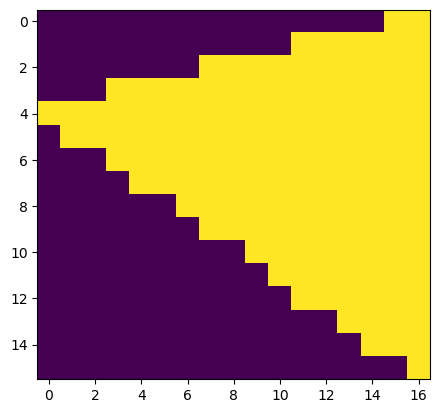

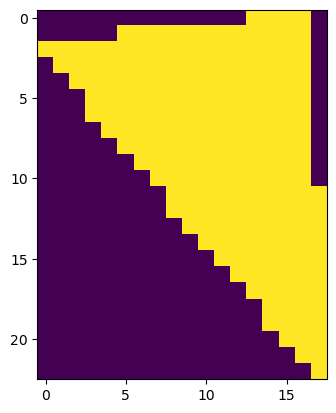

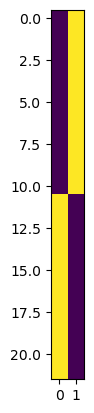

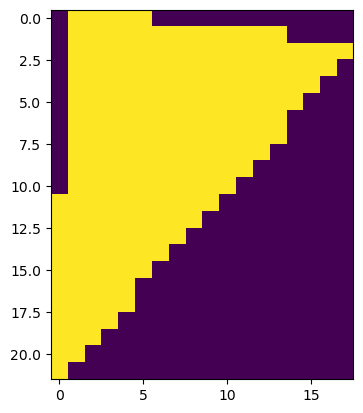

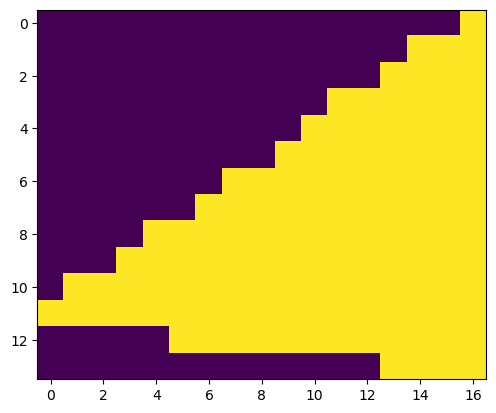

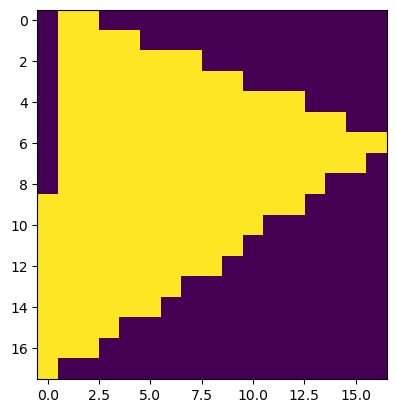

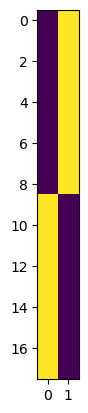

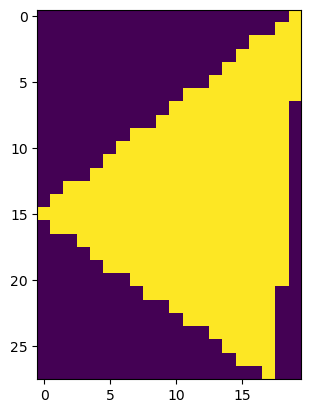

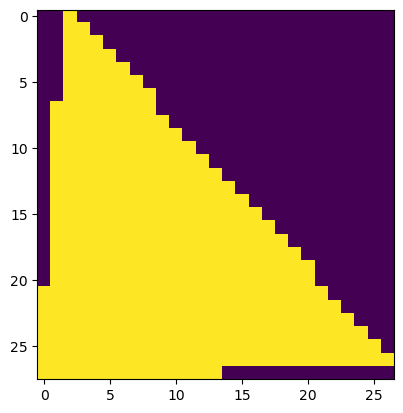

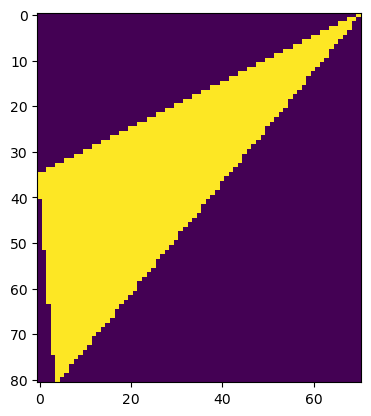

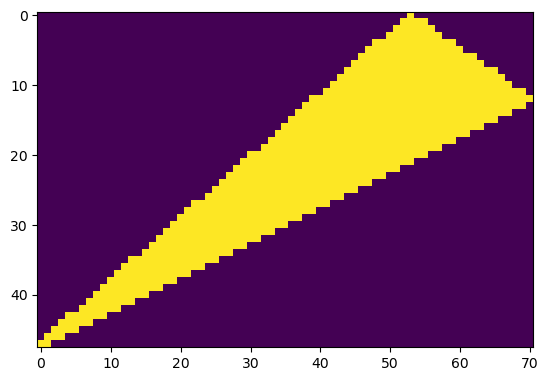

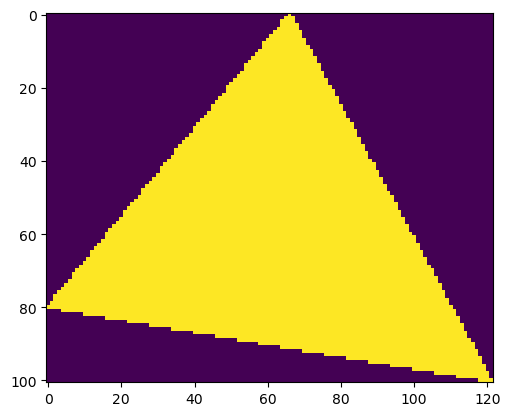

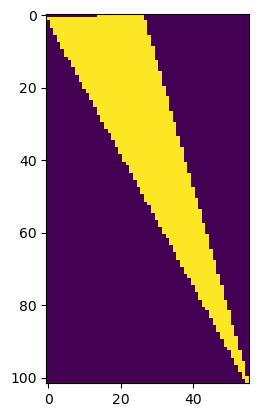

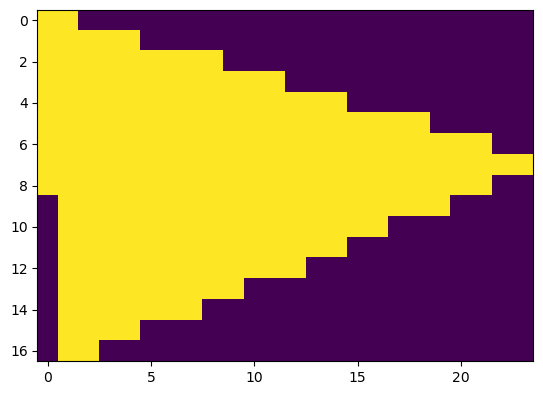

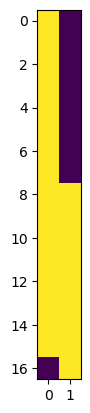

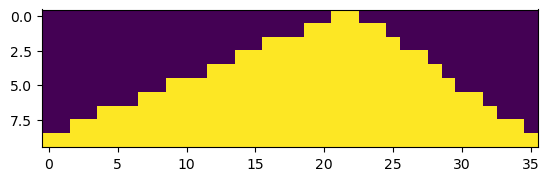

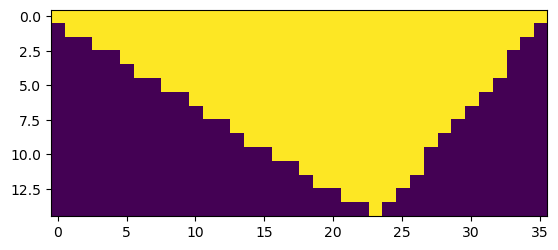

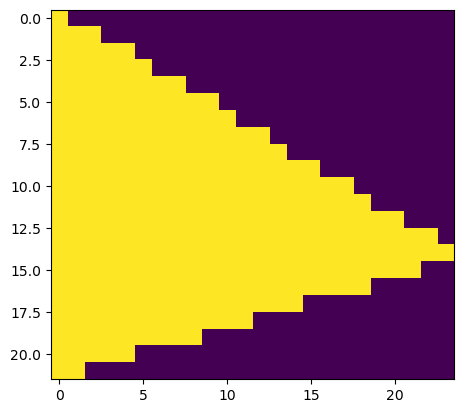

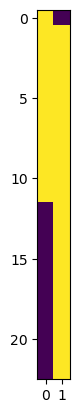

<Figure size 640x480 with 0 Axes>

In [79]:
# for image in f.trans_masks:
#     plt.imshow(image)
#     plt.figure()